## Confidence Metrics



#### Confidence Metric 1: Entropy measure

Entropy measures the spread or unpredictability of the model’s output probabilities. If the entropy is low, it means the model has a clear preference for certain tokens and is more confident in its predictions, while high entropy suggests the model is uncertain about which token to prefer.

This confidence metric can help us guide the sampling of next tokens. If the entropy is low, the model is more confident and the most probable token is likely to be the correct one. In this case, we can limit the sampling space by reducing the temperature, decreasing the value of k in top-k sampling, or increasing the value of p in top-p sampling, to focus on the most likely tokens. We'll use next this principle to dynamically control our text generation.

#### Confidence Metric 2: Attention score with the prompt

This confidence metric is designed to evaluate how aligned the model’s last generated token is with the original prompt. The underlying idea is that, in many cases, we want to assess how confidently the model is generating a response to the given prompt, as sometimes the model might veer off track due to poorly sampled tokens. To measure this confidence at each iteration, we sum the attention scores between the last generated token and the tokens in the initial prompt, across all attention heads, and then calculate the average of these scores.

In fact, if the last token generated by the model is not related to the prompt, its attention scores with the prompt will be low, signaling that the model is not attending to the relevant parts of the prompt. On the other hand, when the last token is highly relevant to the prompt, the attention scores will be higher, indicating that the token is likely contributing to a coherent and relevant response. This method helps ensure that the model maintains focus on the prompt and produces more relevant outputs, especially when the model might otherwise lose track of its intended goal.

## New generation strategy

### Dynamic Beam Search using the confidence metrics

We use beam search to identify the best sequence that responds most effectively to the prompt. The score used to choose the best sequence between the candidates is the cumulative attention score between the generated tokens and the prompt [(see confidence metric 2)](https://colab.research.google.com/drive/1f5fpoBJhMiX1LMfabICHKLUE353BuqSC#scrollTo=Confidence_Metric_2_Attention_score_with_the_prompt)

We use entropy in orther to control the number of candidates we will add to the beam at each iteration of the beam search. We add the top k candidates to the beam at each iteration in term of logits where k is dynamically chosen based on entropy [( see confidence metric 1)](https://colab.research.google.com/drive/1f5fpoBJhMiX1LMfabICHKLUE353BuqSC#scrollTo=Confidence_Metric_1_Entropy_measure)

The use of beam search enables the model to explore multiple candidate sequences simultaneously, maintaining the most promising ones based on their scores. By incorporating both the entropy and attention score as confidence metrics, the model balances exploration and exploitation based on it's confidence at each step.

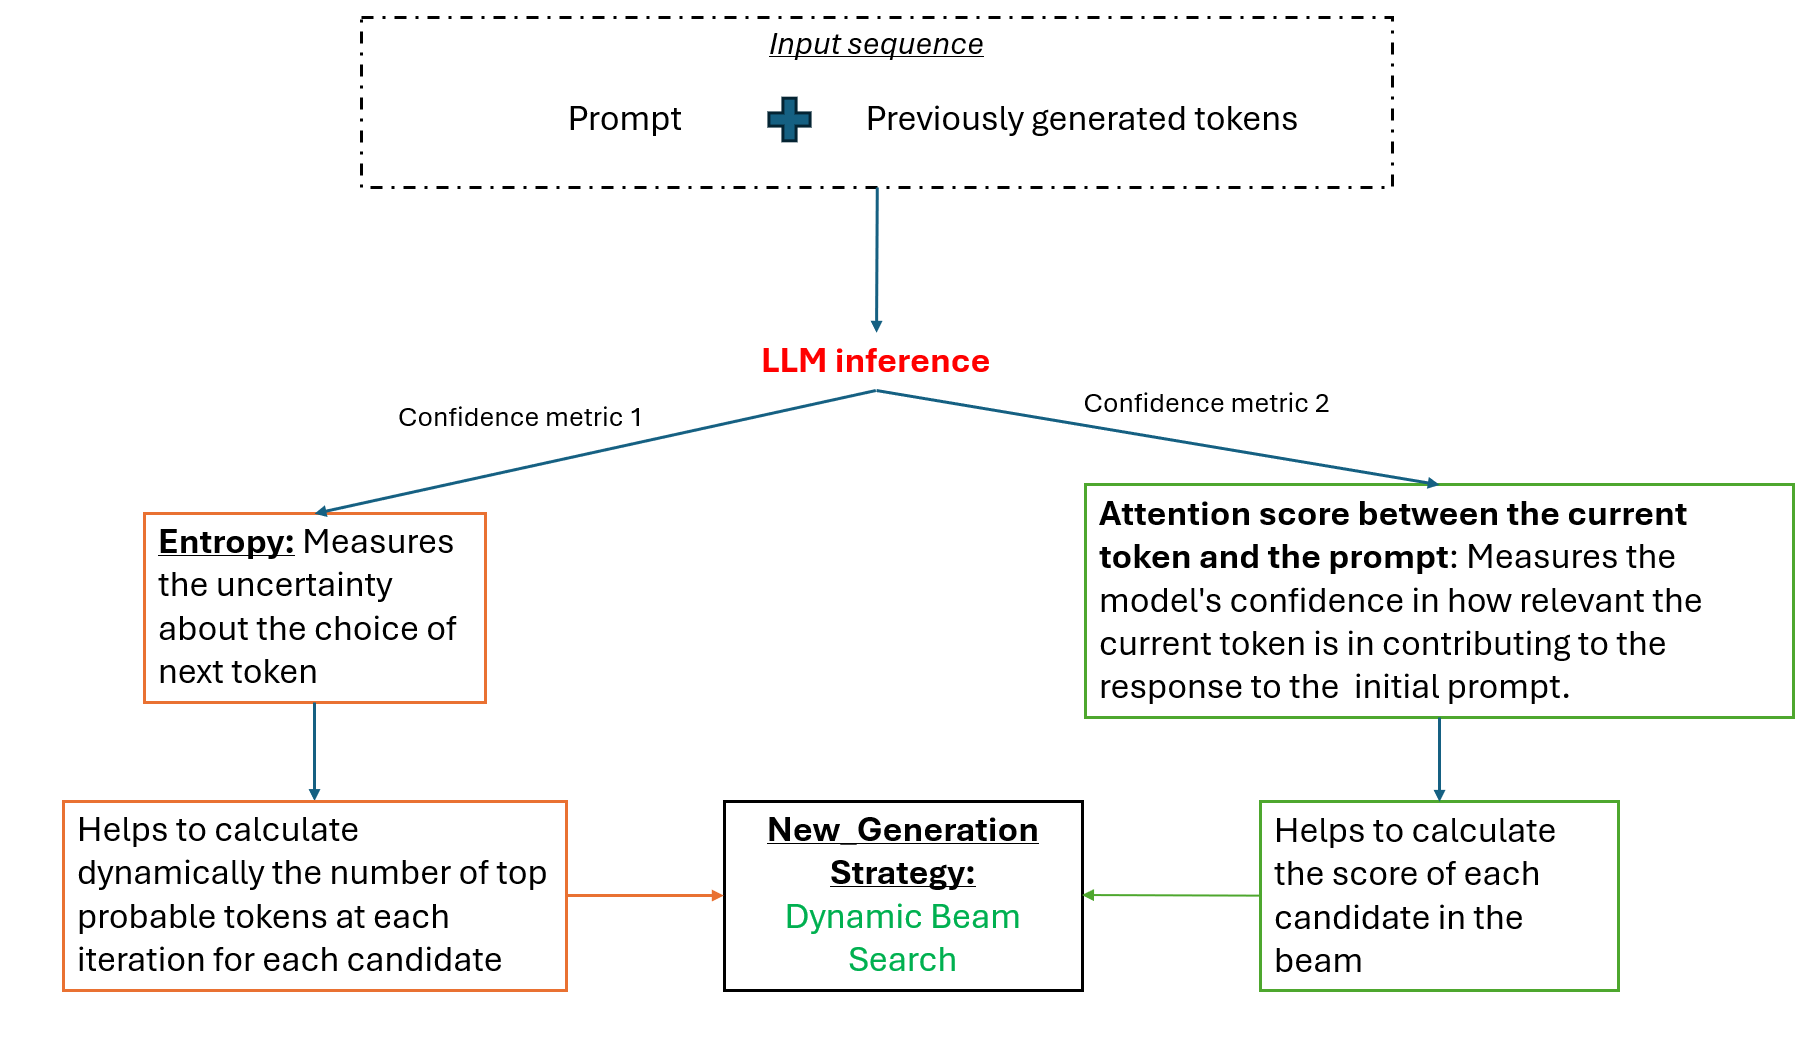

### Implementation

In [ ]:
# Input parameters for text generation. Feel free to play around with them.
MODEL_ID = "HuggingFaceTB/SmolLM2-135M-Instruct"
MAX_TOKENS = 50
messages = [{"role": "user", "content": "What is the capital of France?"}]
SEED = 42 # Set to a non-None positive integer for reproducibility

# NOTE (joao): something is off with randomness when I tried running on colab+T4, on 2025-Jan-06.
# If you're having issues obtaining different results when you change `SEED` (or when `SEED=None`), make sure you
# re-run the cell where the model is loaded.

In [ ]:
# Load the model and prepare inputs for text generation
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed
import torch

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
model = AutoModelForCausalLM.from_pretrained(MODEL_ID, device_map="auto")
INPUT_TEXT=tokenizer.apply_chat_template(messages, tokenize=False)
input_ids = tokenizer(INPUT_TEXT, return_tensors="pt").input_ids.to(model.device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/3.76k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/861 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

In [ ]:
import torch.nn.functional as F

def calculate_entropy(logits):
    """Calculate entropy as a confidence metric."""
    probs = F.softmax(logits, dim=-1)
    entropy = -torch.sum(probs * torch.log(probs + 1e-9), dim=-1)
    return entropy

In [ ]:

# Beam search parameters
beam_width = 2  # Number of candidate sequences to maintain
MAX_TOKENS = 50  # Maximum token length
instruction_beginning = 26 # position of the beginning of the instruction in the prompt.
completed_sequences = []  # Store completed sequences with their scores
SCALE_FACTOR = 5 # Scale factor to calculate the beam width knowing the entropy
prompt_length = len(input_ids)
# Initialize the beam with the start token
beam = [{"sequence": input_ids, "score": 0.0}]  # Each entry is a dict with sequence and cumulative score

# Beam search loop
while len(beam) > 0 and len(completed_sequences) < beam_width:
    next_beam = []

    for candidate in beam:
        input_ids = candidate["sequence"]
        cumulative_score = candidate["score"]

        # Run the forward pass of the model
        model_outputs = model(input_ids=input_ids, output_attentions=True)
        next_token_logits = model_outputs.logits[:, -1, :]
        entropy = calculate_entropy(next_token_logits)
        next_token_probabilities = torch.nn.functional.softmax(next_token_logits, dim=-1)

        # Get top-k tokens for beam expansion where k is dynamically chosen using entropy
        dynamic_beam_width = max(1, int(entropy.item() * SCALE_FACTOR))
        topk_indices = next_token_probabilities.topk(dynamic_beam_width, dim=-1).indices

        # Access attention weights to calculate the beam search score (confidence metric 2)
        attention_weights = model_outputs.attentions
        if attention_weights:
            last_layer_attention = attention_weights[-1]  # Shape: (batch_size, num_heads, seq_len, seq_len)
            attention_upto_n = last_layer_attention[:, :, :, instruction_beginning:prompt_length]
            attention_sum = attention_upto_n.sum(dim=-1)  # Shape: (batch_size, num_heads, seq_len)
            attention_mean = attention_sum.mean(dim=1)
            attention_score = attention_mean[0][-1].item()
        else:
            attention_score = 0.0  # Default if no attention available

        # Expand the beam
        for i in range(dynamic_beam_width):
            next_token_id = topk_indices[:, i]
            new_sequence = torch.cat([input_ids, next_token_id.unsqueeze(-1)], dim=-1)

            # Calculate new cumulative score
            new_score = cumulative_score + attention_score
            next_beam.append({"sequence": new_sequence, "score": new_score})

    # Prune to keep only top `beam_width` sequences
    next_beam = sorted(next_beam, key=lambda x: x["score"], reverse=True)[:beam_width]

    # Check for completed sequences
    beam = []
    for candidate in next_beam:
        if candidate["sequence"].shape[1] >= MAX_TOKENS:
            completed_sequences.append(candidate)
        else:
            beam.append(candidate)

# Finalize output: Get the best sequence based on confidence metric 2
completed_sequences = sorted(completed_sequences, key=lambda x: x["score"], reverse=True)
best_sequence = completed_sequences[0]["sequence"]

# Decode the best sequence
output_text = tokenizer.decode(best_sequence.squeeze().tolist(), skip_special_tokens=True)
print("Best Sequence: ", output_text)


LlamaModel is using LlamaSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Best Sequence:  system
You are a helpful AI assistant named SmolLM, trained by Hugging Face
user
What is the capital of France?
assistant
The capital of France is Paris.
system



## Exploration

*Let*'s experiment the strategy on the 3 types of prompts.

In [ ]:
# Function to evaluate the beam search on different types of prompts
def evaluate_prompts(model, tokenizer, strategy):
    # Define different types of prompts
    message1 = [{"role": "user", "content": "Explain the role of water in regulating Earth's climate and how human activities affect this balance."}]
    question1 = tokenizer.apply_chat_template(message1, tokenize=False)
    message2 = [{"role": "user", "content": "Write a short story about a time traveler who arrives in a futuristic world where humans and robots coexist. The traveler must decide whether to help a group of rebels or align with the authorities."}]
    question2 = tokenizer.apply_chat_template(message2, tokenize=False)
    message3 = [{"role": "user", "content": "Describe how a medieval castle was designed to defend against invaders and how this evolved over time."}]
    question3 = tokenizer.apply_chat_template(message3, tokenize=False)

    # Tokenize the input prompts
    input_ids_1 = tokenizer(question1, return_tensors="pt").input_ids.to(model.device)
    input_ids_2 = tokenizer(question2, return_tensors="pt").input_ids.to(model.device)
    input_ids_3 = tokenizer(question3, return_tensors="pt").input_ids.to(model.device)

    # define generation strategy
    if strategy == "baseline":
      generate_function = baseline
    elif strategy == "beam_search":
      generate_function = beam_search
    else:
      raise ValueError("Invalid strategy. Choose 'baseline' or 'beam_search'.")

    # Evaluate each prompt with the beam search function
    print("Evaluating Scientific Question:")
    print("-------------------------------")
    easy_result = generate_function(model, tokenizer, input_ids_1, 300)
    print("Answer: ", easy_result)

    print("\n\nEvaluating Ambiguous Historic Question:")
    print("--------------------------------------------")
    ambiguous_result = generate_function(model, tokenizer, input_ids_3, 300)
    print("Answer: ", ambiguous_result)

    print("\n\nEvaluating  Story Generation:")
    print("-------------------------------")
    reasoning_result = generate_function(model, tokenizer, input_ids_2, 300)
    print("Answer: ", reasoning_result)


### Baseline strategy

In [ ]:
# Function to perform beam search with dynamic beam width
def baseline(model, tokenizer, input_ids, MAX_TOKENS):
    while input_ids.shape[1] < MAX_TOKENS:
      # Run the forward pass of the model
      model_outputs = model(input_ids=input_ids)
      # Get the next token logits (and probabilities) from the model output
      next_token_logits = model_outputs.logits[:, -1, :]
      next_token_probabilities = torch.nn.functional.softmax(next_token_logits, dim=-1)
      # Sample the next token
      # next_token_id = torch.multinomial(next_token_probabilities, num_samples=1)
      next_token_id = torch.argmax(next_token_probabilities, dim=-1, keepdim=True)
      # Concatenate the sampled token to the input
      input_ids = torch.cat([input_ids, next_token_id], dim=-1)

    # Decode the best sequence to text
    output_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
    return output_text


In [ ]:
evaluate_prompts(model, tokenizer, "baseline")

Evaluating Scientific Question:
-------------------------------
Answer:  system
You are a helpful AI assistant named SmolLM, trained by Hugging Face
user
Explain the role of water in regulating Earth's climate and how human activities affect this balance.
assistant
Water plays a crucial role in regulating Earth's climate by influencing the Earth's temperature, precipitation patterns, and overall climate system. It is essential for the Earth's water cycle, which includes the movement of water from the oceans to the atmosphere, and the condensation of water vapor into clouds.

Water is essential for the Earth's climate because it:

1. Regulates the Earth's temperature: Water is the primary component of the Earth's atmosphere, and its temperature is closely tied to the Earth's climate. Changes in water vapor levels can lead to changes in temperature, which in turn can affect the Earth's climate.

2. Influences precipitation patterns: Water is the primary component of the Earth's precipita

### Beam search strategy

In [ ]:
# Function to perform beam search with dynamic beam width
def beam_search(model, tokenizer, input_ids, MAX_TOKENS):
    completed_sequences = []  # Store completed sequences with their scores

    # defining the beginning and ending position of the prompt
    prompt_length = len(input_ids[0])
    message = [{"role": "user", "content": ""}]
    chat_template_ids = tokenizer(tokenizer.apply_chat_template(message, tokenize=False), return_tensors="pt").input_ids.to(model.device)
    prompt_beginning = len(chat_template_ids[0])

    beam = [{"sequence": input_ids, "score": 0.0}]  # Initialize beam with the start token

    while len(beam) > 0 and len(completed_sequences) < beam_width:
        next_beam = []

        for candidate in beam:
            input_ids = candidate["sequence"]
            cumulative_score = candidate["score"]

            # Run the forward pass of the model
            model_outputs = model(input_ids=input_ids, output_attentions=True)
            next_token_logits = model_outputs.logits[:, -1, :]
            entropy = calculate_entropy(next_token_logits)
            next_token_probabilities = F.softmax(next_token_logits, dim=-1)

            # Get dynamic beam width based on entropy
            dynamic_beam_width = max(1, int(entropy.item() * SCALE_FACTOR))
            topk_indices = next_token_probabilities.topk(dynamic_beam_width, dim=-1).indices

            # Access attention weights to calculate the attention score
            attention_weights = model_outputs.attentions
            if attention_weights:
                last_layer_attention = attention_weights[-1]  # Shape: (batch_size, num_heads, seq_len, seq_len)
                attention_upto_n = last_layer_attention[:, :, :, prompt_beginning:prompt_length]
                attention_sum = attention_upto_n.sum(dim=-1)  # Shape: (batch_size, num_heads, seq_len)
                attention_mean = attention_sum.mean(dim=1)
                attention_score = attention_mean[0][-1].item()
            else:
                attention_score = 0.0  # Default if no attention available

            # Expand the beam
            for i in range(dynamic_beam_width):
                next_token_id = topk_indices[:, i]
                new_sequence = torch.cat([input_ids, next_token_id.unsqueeze(-1)], dim=-1)

                # Calculate new cumulative score (based on attention score)
                new_score = cumulative_score + attention_score
                next_beam.append({"sequence": new_sequence, "score": new_score})

        # Prune to keep only top `beam_width` sequences
        next_beam = sorted(next_beam, key=lambda x: x["score"], reverse=True)[:beam_width]

        # Check for completed sequences (if the sequence reaches max tokens)
        beam = []
        for candidate in next_beam:
            if candidate["sequence"].shape[1] >= MAX_TOKENS:
                completed_sequences.append(candidate)
            else:
                beam.append(candidate)

    # Finalize output: Get the best sequence based on the highest score
    completed_sequences = sorted(completed_sequences, key=lambda x: x["score"], reverse=True)
    best_sequence = completed_sequences[0]["sequence"]

    # Decode the best sequence to text
    output_text = tokenizer.decode(best_sequence.squeeze().tolist(), skip_special_tokens=True)
    return output_text



In [ ]:
evaluate_prompts(model, tokenizer, "beam_search")

Evaluating Scientific Question:
-------------------------------
Answer:  system
You are a helpful AI assistant named SmolLM, trained by Hugging Face
user
Explain the role of water in regulating Earth's climate and how human activities affect this balance.
assistant
The role of water in regulating Earth's climate and human activities affecting this balance.

Human activity significantly impacts the balance of the Earth's climate and its ability to regulate its temperature. Water is a critical component in this process.

Human activity, such as the extraction and use of water for various purposes like agriculture, industrial, and domestic purposes, can alter water resources and affect the climate.

For instance, the extraction of water for agriculture can lead to water scarcity and increased demand for water resources. In turn, increased water consumption can increase the demand for water resources and alter the water balance.

Similarly, the use of non-renewable sources of water like gr

### Observations



1.   **Scientific question**

Compared to the baseline strategy, the generated text of the new strategy don't explain the role of the water in regulating the temperature and answers directly the second instruction. The baseline model is also more structered with numbered list.   

2.   **Ambiguous Historic question**

This time the new strategy is better than the baseline strategy. We can see that the new strategy directly responds to the question, while the classical strategy repeats itself and much more unecessary iterations were needed before having the answer to the question.

3. **Story Generation**

We can see that the second strategy leads to a more rapid narration of the events asked to be narrated in the prompt, while the baseline model generates many rare words and is more inventive and takes more steps before narrating the next event.



### Conclusion

Based on only these few examples on instruction type prompts, we can make those observations:


*   The new strategy tends to answer more rapidely the question without unecessary iterations. This can be due to the fact that the attention score used in the beam search, selects the candidates that are the more important in relation to the prompt. But more tests should be done to really confirm this interpretation such as the effect of the scaling factor.
*   The new strategy seems to favors exploitation more than exploration. This is illustrated in the third example which is not desired in some scenarios like the generation of a story.



## Small Report: Future Directions

If I had an additional week to continue this exploration, here is what I would have done:
#### Extensive Testing on Various Datasets
To evaluate the impact of the dynamic beam search strategy on the quality of generated texts, I would like to conduct additional tests on open-source datasets and custom datasets generated by other LLMs. One specific experiment for example could involve testing the strategy on question-response datasets to compare the average size of correct responses with the new strategy versus the standard strategy. This comparison would help determine if the new strategy has the potential to improve response quality and conciseness. Other tests can be to see the effect of the scaling factor used to derive the number of candidates to be selected, from the entropy.

#### Development of a Machine Learning Model to improve sampling
If the results from the extensive testing prove promising, I would like to develop a machine learning model, either a regression model or a reinforcement learning model, to select the appropriate temperature, top-k value, or top-p value based on various confidence metrics instead of solely relying on a scaling hyperparameter for entropy. This would involve labeling a training dataset (for example the minimum k to get the correct token) or creating an environment with a reward system to train the model effectively.
#### Exploration of Improved Prompt Relevance Metrics
Additionally, I would like to explore alternative strategies to the attention metric for evaluating whether the model remains on the correct path to respond to the question. The idea is to try to learn the probability of the question given the generated tokens. Finally to push the boundaries of this research further, I would delve into exploring more state-of-the-art  test-time compute methods.
